In [1]:

import os
from cleverhans.attacks import FastGradientMethod
import numpy as np
import pandas as pd
from io import BytesIO
import IPython.display
import warnings
with warnings.catch_warnings():
    
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py

In [2]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim

In [3]:
tensorflow_master = ""
checkpoint_path   = r"C:\Users\dell15\inception\inception_v3.ckpt"

In [4]:
input_dir         = r"C:\Users\dell15\adversarial"
max_epsilon       = 16.0
image_width       = 299
image_height      = 299
batch_size        = 16

eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001

In [5]:
from scipy.misc import imread
from scipy.misc import imsave
from PIL import Image
from scipy.misc import imread
from scipy.misc import imsave
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    #print (images)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


In [6]:
class InceptionModel(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return probs

In [7]:
categories = pd.read_csv("categories.csv")
image_classes = pd.read_csv("images.csv")
image_iterator = load_images(input_dir, batch_shape)

C:\Users\dell15\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Testing 1st image


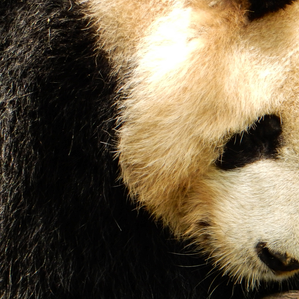

In [8]:
filenames, images = next(image_iterator)

image_metadata = pd.DataFrame({"ImageId": [f[:-4] for f in filenames]}).merge(image_classes,
                                                                              on="ImageId")
true_classes = image_metadata["TrueLabel"].tolist()
target_classes = true_labels = image_metadata["TargetClass"].tolist()
true_classes_names = (pd.DataFrame({"CategoryId": true_classes})
                        .merge(categories, on="CategoryId")["CategoryName"].tolist())
target_classes_names = (pd.DataFrame({"CategoryId": target_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

print("Testing 1st image")
show_image(images[0])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell15\inception\inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
real image left and non targeted adversaial right


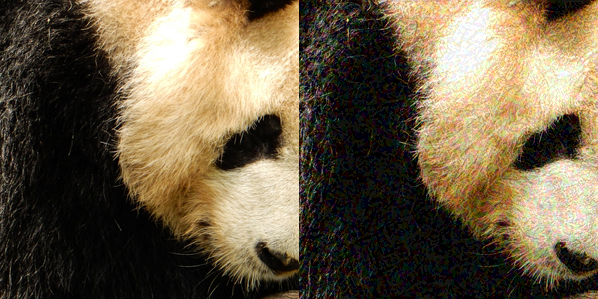

In [9]:
tf.logging.set_verbosity(tf.logging.INFO)

with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)
    model = InceptionModel(num_classes)

    fgsm  = FastGradientMethod(model)
    x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        nontargeted_images = sess.run(x_adv, feed_dict={x_input: images})

print("real image left and non targeted adversaial right")
show_image(np.concatenate([images[0], nontargeted_images[0]], axis=1))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell15\inception\inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The original image is on the left, and the targeted adversarial image is on the right.


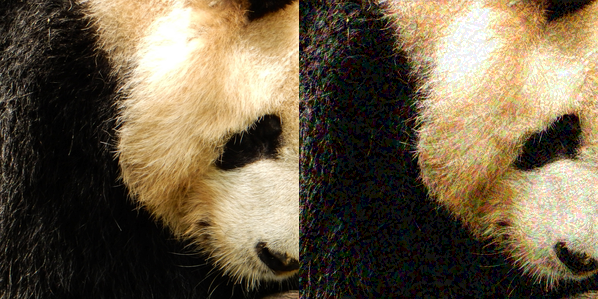

In [18]:
all_images_target_class = {image_metadata["ImageId"][i]+".png": image_metadata["TargetClass"][i]
                           for i in image_metadata.index}

with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, end_points = inception.inception_v3(
            x_input, num_classes=num_classes, is_training=False)

    target_class_input = tf.placeholder(tf.int32, shape=[batch_size])
    one_hot_target_class = tf.one_hot(target_class_input, num_classes)
    cross_entropy = tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                    logits,
                                                    label_smoothing=0.1,
                                                    weights=1.0)
    cross_entropy += tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                     end_points['AuxLogits'],
                                                     label_smoothing=0.1,
                                                     weights=0.4)
    x_adv = x_input - eps * tf.sign(tf.gradients(cross_entropy, x_input)[0])
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
        scaffold=tf.train.Scaffold(saver=saver),
        checkpoint_filename_with_path=checkpoint_path,
        master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        target_class_for_batch = ([all_images_target_class[n] for n in filenames]
                                  + [0] * (batch_size - len(filenames)))
        targeted_images = sess.run(x_adv,
                                   feed_dict={x_input: images,
                                              target_class_input: target_class_for_batch})
        
print("The original image is on the left, and the targeted adversarial image is on the right.")
show_image(np.concatenate([images[0], targeted_images[0]], axis=1))

In [21]:
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
        predicted_nontargeted_classes = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
        predicted_targeted_classes = sess.run(predicted_labels, feed_dict={x_input: targeted_images})

predicted_classes_names = (pd.DataFrame({"CategoryId": predicted_classes})
                           .merge(categories, on="CategoryId")["CategoryName"].tolist())

predicted_nontargeted_classes_names = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

predicted_targeted_classes_names = (pd.DataFrame({"CategoryId": predicted_targeted_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell15\inception\inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


UNMODIFIED IMAGE (left) 
	Predicted class: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 
	True class:      giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: Samoyed, Samoyede
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: chow, chow chow 
	Target class:    meat loaf, meatloaf


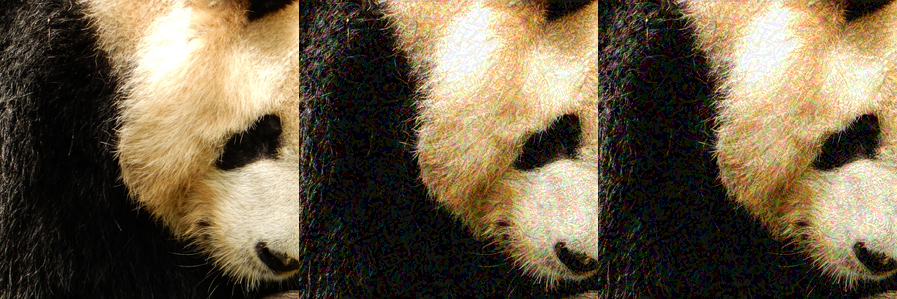

UNMODIFIED IMAGE (left) 
	Predicted class: American coot, marsh hen, mud hen, water hen, Fulica americana 
	True class:      American coot, marsh hen, mud hen, water hen, Fulica americana
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: hippopotamus, hippo, river horse, Hippopotamus amphibius
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: hippopotamus, hippo, river horse, Hippopotamus amphibius 
	Target class:    jacamar


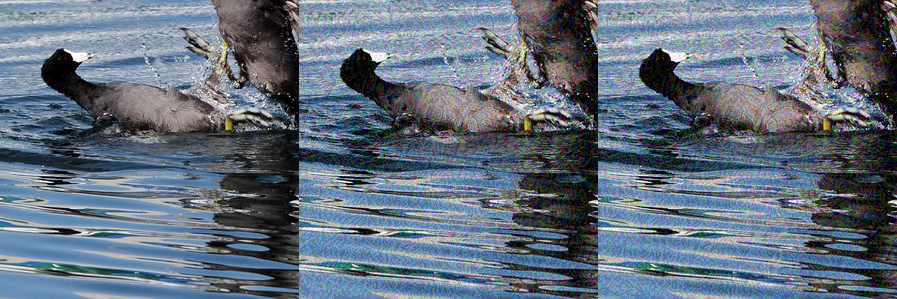

UNMODIFIED IMAGE (left) 
	Predicted class: football helmet 
	True class:      football helmet
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: puck, hockey puck
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: puck, hockey puck 
	Target class:    cockroach, roach


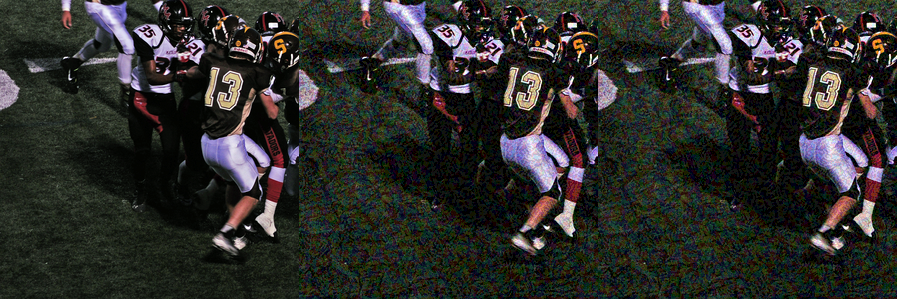

UNMODIFIED IMAGE (left) 
	Predicted class: football helmet 
	True class:      football helmet
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: palace
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: castle 
	Target class:    solar dish, solar collector, solar furnace


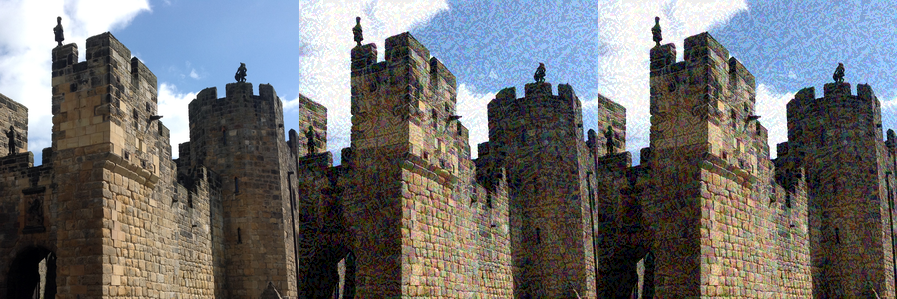

UNMODIFIED IMAGE (left) 
	Predicted class: castle 
	True class:      castle
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: drum, membranophone, tympan
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: jigsaw puzzle 
	Target class:    fountain


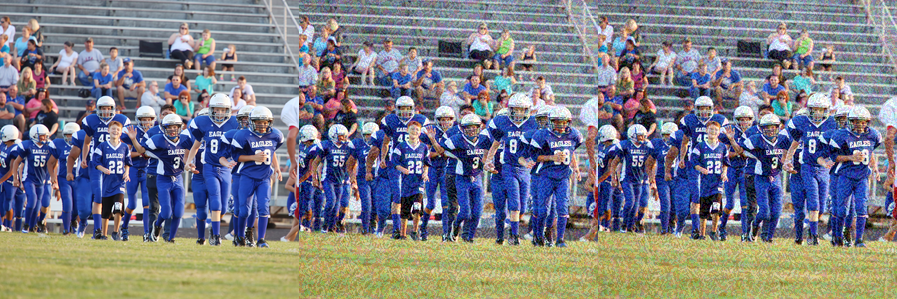

UNMODIFIED IMAGE (left) 
	Predicted class: freight car 
	True class:      freight car
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: dishwasher, dish washer, dishwashing machine
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: dishwasher, dish washer, dishwashing machine 
	Target class:    baseball


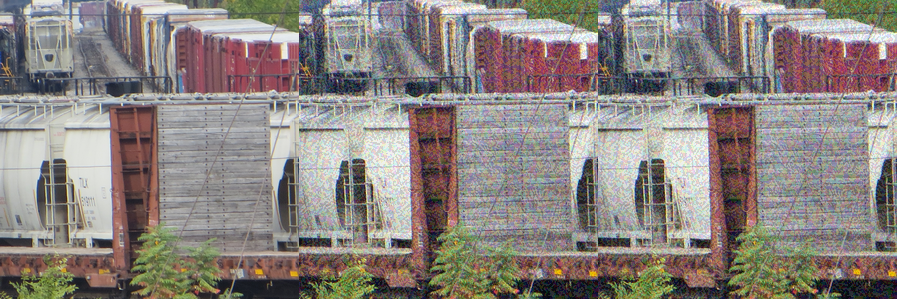

UNMODIFIED IMAGE (left) 
	Predicted class: pier 
	True class:      pier
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: pier
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: pier 
	Target class:    earthstar


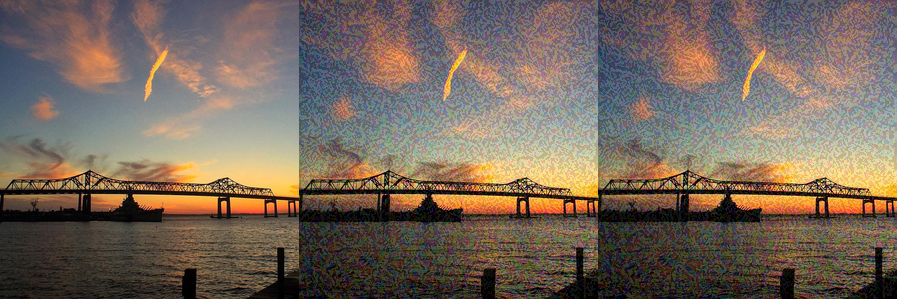

UNMODIFIED IMAGE (left) 
	Predicted class: dung beetle 
	True class:      dung beetle
NONTARGETED ADVERSARIAL IMAGE (center) 
	Predicted class: ground beetle, carabid beetle
TARGETED ADVERSARIAL IMAGE (right) 
	Predicted class: ground beetle, carabid beetle 
	Target class:    scale, weighing machine


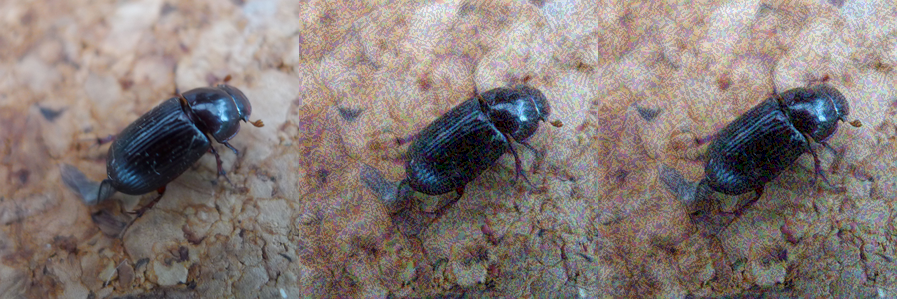

IndexError: list index out of range

In [23]:
for i in range(len(images)):
    print("UNMODIFIED IMAGE (left)",
          "\n\tPredicted class:", predicted_classes_names[i],
          "\n\tTrue class:     ", true_classes_names[i])
    print("NONTARGETED ADVERSARIAL IMAGE (center)",
          "\n\tPredicted class:", predicted_nontargeted_classes_names[i])
    print("TARGETED ADVERSARIAL IMAGE (right)",
          "\n\tPredicted class:", predicted_targeted_classes_names[i],
          "\n\tTarget class:   ", target_classes_names[i])
    show_image(np.concatenate([images[i], nontargeted_images[i], targeted_images[i]], axis=1))

In [63]:
len(images)

16

In [74]:
x = np.ones((75,25600))

In [75]:
x.mean()

1.0

In [81]:
print(1)

1


'C:\\Users\\dell15'

NameError: name 'head' is not defined

AttributeError: 'DataFrame' object has no attribute 'desc'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73147 entries, 0 to 73146
Data columns (total 16 columns):
id                           73147 non-null object
program_id                   73147 non-null object
program_type                 73147 non-null object
program_duration             73147 non-null int64
test_id                      73147 non-null int64
test_type                    73147 non-null object
difficulty_level             73147 non-null object
trainee_id                   73147 non-null int64
gender                       73147 non-null object
education                    73147 non-null object
city_tier                    73147 non-null int64
age                          45418 non-null float64
total_programs_enrolled      73147 non-null int64
is_handicapped               73147 non-null object
trainee_engagement_rating    73070 non-null float64
is_pass                      73147 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 8.9+ MB


id program_id program_type  program_duration  test_id test_type  \
0   9389_150        Y_1            Y               136      150   offline   
1   16523_44        T_1            T               131       44   offline   
2  13987_178        Z_2            Z               120      178    online   
3   13158_32        T_2            T               117       32   offline   
4   10591_84        V_3            V               131       84   offline   

  difficulty_level  trainee_id gender            education  city_tier   age  \
0     intermediate        9389      M        Matriculation          3  24.0   
1             easy       16523      F  High School Diploma          4  26.0   
2             easy       13987      M        Matriculation          1  40.0   
3             easy       13158      F        Matriculation          3   NaN   
4     intermediate       10591      F  High School Diploma          1  42.0   

   total_programs_enrolled is_handicapped  trainee_engagement_rating  is_pass  
0                        5              N                        1.0        0  
1                        2              N                        3.0        1  
2                        1              N                        2.0        1  
3                        4              N                        1.0        1  
4                        2              N                        4.0        1

AttributeError: 'DataFrame' object has no attribute 'column'